In [1]:
from tools import *
d= load_data()
%config InlineBackend.figure_format = 'retina'

C:\Miniconda2\lib\site-packages\matplotlib\axes\_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Miniconda2\lib\site-packages\matplotlib\axes\_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


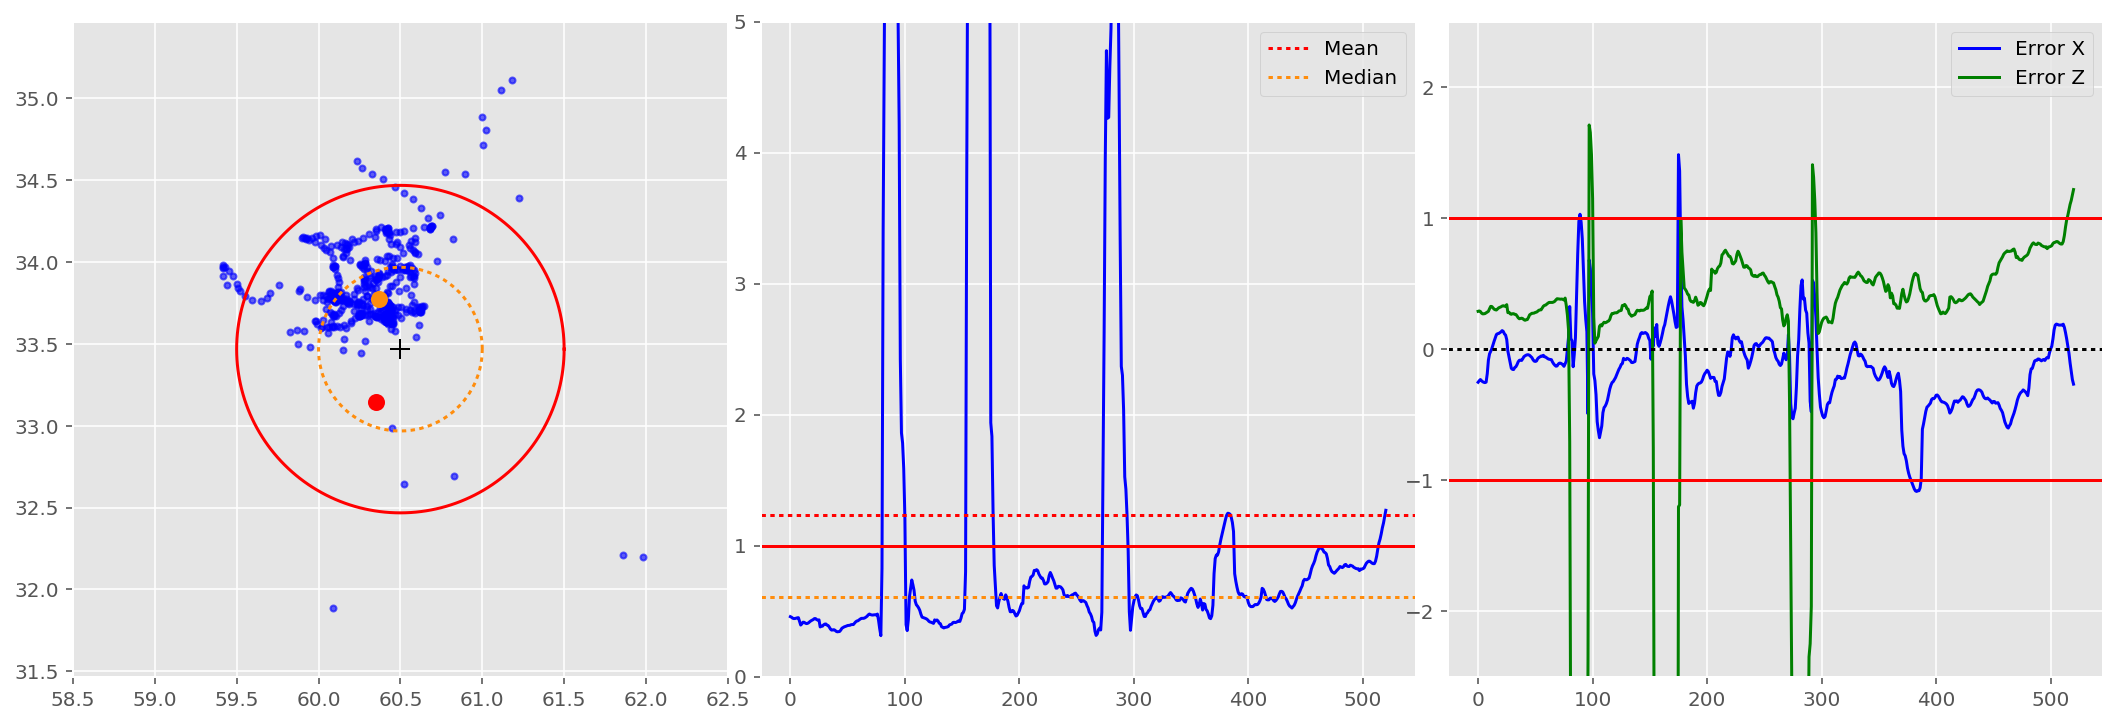

In [2]:
f = check_accuracy(d['P07']['accuracy']['t3'])
plt.show()

In [3]:
np.array(100)

array(100)